### Extracting data from the JSON files

In [12]:
SAMPLE_SIZE = 12000
TRAIN_SIZE = 9000

In [3]:
import numpy as np
import json 
import pandas

business_ratings = { }

for index, line in enumerate(open("data/yelp_academic_dataset_business.json", "r")):
    json_data = json.loads(line)
    rating, bid = json_data["stars"], json_data["business_id"]
    business_ratings[bid] = rating
    
review_list = []
business_index = { }
selected_businesses = set(np.random.choice(business_ratings.keys(), replace=False, size=SAMPLE_SIZE))
for index, bid in enumerate(selected_businesses):
    review_list.append([bid, business_ratings[bid], ""])
    business_index[bid] = index

for line in open("data/yelp_academic_dataset_review.json", "r"):
    json_data = json.loads(line)
    bid = json_data["business_id"]
    if bid in selected_businesses:
        review_list[business_index[bid]][2] += (json_data["text"] + "\n")
               
review_pd = pandas.DataFrame(review_list, columns = ["Business ID", "Business Rating", "Review Text"])

In [4]:
review_pd.head()

,Business ID,Business Rating,Review Text
0,OlpyplEJ_c_hFxyand_Wxw,3.5,I drove to Inchins on their very first day and...
1,yDnRf8m_YI4AXHVGH6-fuQ,4.0,Sur La Table ...you sexy thing. You with your ...
2,d5NCb9EFgsE4oPlnSXdIgg,2.0,Yum. Very healthy and fresh. The potstickers w...
3,dbMpGh4p9dTxSn5lDSKE3w,3.5,"Good food nice ambience, strong coffee and a g..."
4,FFdlPSZCGgTdg1CAfrlvlw,3.5,Very nice location! A little higher class tha...


### Tokenizing the review text

In [5]:
import sys
import string
import unicodedata

tbl = dict.fromkeys(i for i in xrange(sys.maxunicode) if unicodedata.category(unichr(i)).startswith('P'))

def tokenize(text):
    return unicode(text).translate(tbl).lower().split()

review_pd["Tokenized Text"] = review_pd["Review Text"].apply(tokenize)

In [6]:
review_pd.head()

,Business ID,Business Rating,Review Text,Tokenized Text
0,OlpyplEJ_c_hFxyand_Wxw,3.5,I drove to Inchins on their very first day and...,"[i, drove, to, inchins, on, their, very, first..."
1,yDnRf8m_YI4AXHVGH6-fuQ,4.0,Sur La Table ...you sexy thing. You with your ...,"[sur, la, table, you, sexy, thing, you, with, ..."
2,d5NCb9EFgsE4oPlnSXdIgg,2.0,Yum. Very healthy and fresh. The potstickers w...,"[yum, very, healthy, and, fresh, the, potstick..."
3,dbMpGh4p9dTxSn5lDSKE3w,3.5,"Good food nice ambience, strong coffee and a g...","[good, food, nice, ambience, strong, coffee, a..."
4,FFdlPSZCGgTdg1CAfrlvlw,3.5,Very nice location! A little higher class tha...,"[very, nice, location, a, little, higher, clas..."


In [7]:
review_pd.shape

(10000, 4)

### Manipulating data into LabeledSentences

In [7]:
from gensim.models.doc2vec import LabeledSentence
import numpy as np

class LabeledSentences:
    
    def __init__(self, series):
        self.series = series
        
    def __iter__(self):
        indexes = list(np.arange(len(self.series)))
        np.random.shuffle(indexes)
        for (index, wordlist) in self.series.iloc[indexes].iteritems():
            yield LabeledSentence(words = wordlist, tags = ['VEC_%s' % index])
            
sentences = LabeledSentences(review_pd["Tokenized Text"].copy())

### Learn vector representations for each word via Word2Vec

In [29]:
import multiprocessing
import gensim
from gensim.models import Doc2Vec

assert gensim.models.doc2vec.FAST_VERSION > -1, "This will be slow otherwise"
cores = multiprocessing.cpu_count()

model = Doc2Vec(dm = 1, dm_concat = 0, min_count = 1, window = 10, size = 100, sample = 1e-4, negative = 5, 
                workers = cores, alpha = 0.025, min_alpha = 0.025)
model.build_vocab(sentences)

### Learn vector representations for each review text via Doc2Vec

In [30]:
for epoch in range(10):
    model.train(sentences)

### Concatenate Review Rating with Vector

In [32]:
design_matrix, labels = [], []
test_matrix, t_labels = [], []

train_indices = set(np.random.choice(np.arange(len(model.docvecs)), replace=False, size=TRAIN_SIZE))
for index in xrange(len(model.docvecs)):
    key = ("VEC_%s") % (index)
    if index in train_indices:
        design_matrix.append(model.docvecs[key])
        labels.append(review_pd["Business Rating"][index])
    else:
        test_matrix.append(model.docvecs[key])
        t_labels.append(review_pd["Business Rating"][index])
    
design_matrix = np.array(design_matrix)
labels = np.array(labels)

test_matrix = np.array(test_matrix)
t_labels = np.array(t_labels)

(array([    0.,     0.,    62.,    98.,   288.,   608.,   945.,  1495.,
         1519.,  1117.,   868.]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5]),
 <a list of 11 Patch objects>)

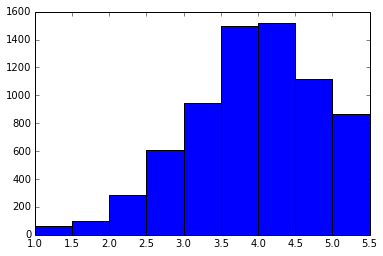

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(labels,bins=[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5])

In [33]:
labels_binary = (labels >= 4).astype(int)
t_labels_binary = (t_labels >= 4).astype(int)

In [17]:
t_labels_binary.sum() * 1.0 / len(t_labels_binary)

0.48966666666666664

### Input data into Binomial Model

In [34]:
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as met

logreg = LogisticRegression()
logreg.fit(design_matrix, labels_binary)

preds = logreg.predict(test_matrix)
print met.accuracy_score(t_labels_binary, preds)

0.822333333333


In [35]:
met.confusion_matrix(t_labels_binary, preds)

array([[1254,  292],
       [ 241, 1213]])

In [36]:
met.precision_score(t_labels_binary, preds)

0.80598006644518272

In [37]:
met.recall_score(t_labels_binary, preds)

0.83425034387895458

### Sentiment Exploration

In [26]:
model.most_similar('busy')

[(u'crowded', 0.7942806482315063),
 (u'packed', 0.6520974636077881),
 (u'hectic', 0.6282860040664673),
 (u'noisy', 0.6179928183555603),
 (u'busier', 0.6126136183738708),
 (u'understaffed', 0.6088256239891052),
 (u'slammed', 0.6029973030090332),
 (u'quiet', 0.5827741026878357),
 (u'hoppin', 0.5640619397163391),
 (u'slow', 0.5494919419288635)]

In [25]:
model.most_similar('good')

[(u'fair', 0.5662207007408142),
 (u'amazing', 0.5327524542808533),
 (u'reasonable', 0.5316596627235413),
 (u'decent', 0.5266270637512207),
 (u'affordable', 0.5084173083305359),
 (u'important', 0.4876272678375244),
 (u'brigantine', 0.4784700870513916),
 (u'overpriced', 0.47548869252204895),
 (u'awesome', 0.4750751852989197),
 (u'outstanding', 0.4734727144241333)]

In [27]:
model.most_similar('service')

[(u'terisa', 0.5031445026397705),
 (u'reviewpost', 0.4956582188606262),
 (u'slowsince', 0.4931017756462097),
 (u'pratice', 0.4908463954925537),
 (u'televisi\xf3n', 0.4890173375606537),
 (u'customer', 0.48583510518074036),
 (u'food', 0.4808298945426941),
 (u'presentation', 0.4737012982368469),
 (u'ambience', 0.47268861532211304),
 (u'ambiance', 0.47012561559677124)]

### Input data into Multiclass Logistic Regression Model

In [2]:
import numpy as np
import json 
import pandas
from collections import Counter

TARGET = 2000
business_classes = { 1 : 0, 1.5: 0, 2: 0, 2.5 : 0, 3 : 1, 3.5 : 2, 4 : 3, 4.5 : 4, 5 : 5 }
business_priors = Counter()
business_ratings = { }

for index, line in enumerate(open("data/yelp_academic_dataset_business.json", "r")):
    json_data = json.loads(line)
    rating, bid = json_data["stars"], json_data["business_id"]
    if business_priors[business_classes[rating]] < TARGET:
        business_priors[business_classes[rating]] += 1
        business_ratings[bid] = rating
    
review_list = []
business_index = { }
for index, bid in enumerate(business_ratings.keys()):
    review_list.append([bid, business_ratings[bid], ""])
    business_index[bid] = index

for line in open("data/yelp_academic_dataset_review.json", "r"):
    json_data = json.loads(line)
    bid = json_data["business_id"]
    if bid in business_ratings:
        review_list[business_index[bid]][2] += (json_data["text"] + "\n")
               
review_pd = pandas.DataFrame(review_list, columns = ["Business ID", "Business Rating", "Review Text"])

In [6]:
review_pd["Tokenized Text"] = review_pd["Review Text"].apply(tokenize)
review_pd.head()

,Business ID,Business Rating,Review Text,Tokenized Text
0,qQ_llmpx3ANoeiyG_6rasA,5.0,Bill came out to check on our garage door that...,"[bill, came, out, to, check, on, our, garage, ..."
1,mA6fwSD7HaXL1QG-jkb2Hw,4.0,Why is it that retail associates either bombar...,"[why, is, it, that, retail, associates, either..."
2,ykBWmSL1yDrAob2a20b2DQ,2.5,This is the place to go for an inexpensive ped...,"[this, is, the, place, to, go, for, an, inexpe..."
3,VZYMInkjRJVHwXVFqeoMWg,3.5,I know. You are reading this and wanting to ri...,"[i, know, you, are, reading, this, and, wantin..."
4,GXNLitPTpkBwc_IXGzBEvQ,4.5,"Edited as of July 16, 2010 to make this a 5 st...","[edited, as, of, july, 16, 2010, to, make, thi..."


In [49]:
design_matrix, labels = [], []
test_matrix, t_labels = [], []

train_indices = set(np.random.choice(np.arange(len(model.docvecs)), replace=False, size=TRAIN_SIZE))
for index in xrange(len(model.docvecs)):
    key = ("VEC_%s") % (index)
    if index in train_indices:
        design_matrix.append(model.docvecs[key])
        labels.append(business_classes[review_pd["Business Rating"][index]])
    else:
        test_matrix.append(model.docvecs[key])
        t_labels.append(business_classes[review_pd["Business Rating"][index]])
    
design_matrix = np.array(design_matrix)
labels = np.array(labels).astype(int)

test_matrix = np.array(test_matrix)
t_labels = np.array(t_labels).astype(int)

In [50]:
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as met

logreg = LogisticRegression(multi_class = "multinomial", solver = "lbfgs")
logreg.fit(design_matrix, labels)

preds = logreg.predict(test_matrix)
print met.accuracy_score(t_labels, preds)

0.475333333333


(array([ 530.,  520.,  492.,  497.,  475.,  486.]),
 array([ 0.        ,  0.83333333,  1.66666667,  2.5       ,  3.33333333,
         4.16666667,  5.        ]),
 <a list of 6 Patch objects>)

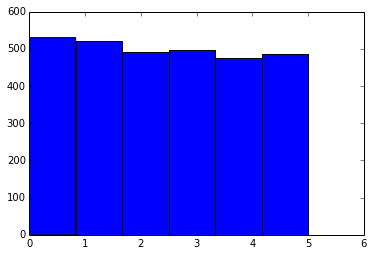

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(t_labels, bins = 6)

In [79]:
stars = np.array(business_ratings.values())
(stars == 3).sum()

8335